In [21]:
import torch
from torchvision import transforms, datasets, models
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision.utils import save_image

In [2]:
device = "gpu" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cpu'

In [142]:
def load_image(path):
    image = Image.open(path)
    image = loader(image).unsqueeze(0)
    return image if device!= 'gpu' else image.cuda()

In [12]:
imsize = 356
loader = transforms.Compose([transforms.Resize((imsize, imsize)), transforms.ToTensor(),
                             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [145]:
original = load_image('target.png')
style = load_image('style.jpg')
generated = original.clone().requires_grad_(True)

In [16]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        # chosen layers : conv1_1, conv2_1, conv3_1, conv4_1, conv5_1
        self.chosen_features = ["0", "5", "10", "19", "28"]
        self.model = models.vgg19(pretrained=True).features[:29]
        
    def forward(self, x):
        features = []
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            if str(layer_num) in self.chosen_features:
                features.append(x)
        return features

In [143]:
model = VGG().eval() if device != 'gpu' else VGG().cuda().eval()

In [147]:
total_steps = 6000
learning_rate = 0.001
alpha = 1
beta = 0.001
optimizer = optim.Adam([generated], lr=learning_rate)

In [29]:
for step in range(total_steps):
    generated_features = model(generated)
    original_img_features = model(original)
    style_features = model(style)
    style_loss, target_loss = 0, 0
    for gen_feature, orig_feature, sty_feature in zip(generated_features, original_img_features, style_features):
        batch_size, channel, height, width = gen_feature.shape
        target_loss += torch.mean((gen_feature - orig_feature) ** 2)
        G = gen_feature.view(channel, height * width).mm(gen_feature.view(channel, height * width).t())
        A = sty_feature.view(channel, height * width).mm(sty_feature.view(channel, height * width).t())
        style_loss += torch.mean((G - A) ** 2)
    
    total_loss = alpha * target_loss + beta * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if step % 200 == 0:
        print(total_loss)
        save_image(generated, 'generated.png' )

tensor(60728180., grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [120]:
def img_convert(img_data):
    img_data = np.transpose(img_data, (1,2,0))
    img_data = img_data * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    img_data = img_data.clip(0,1)
    return img_data

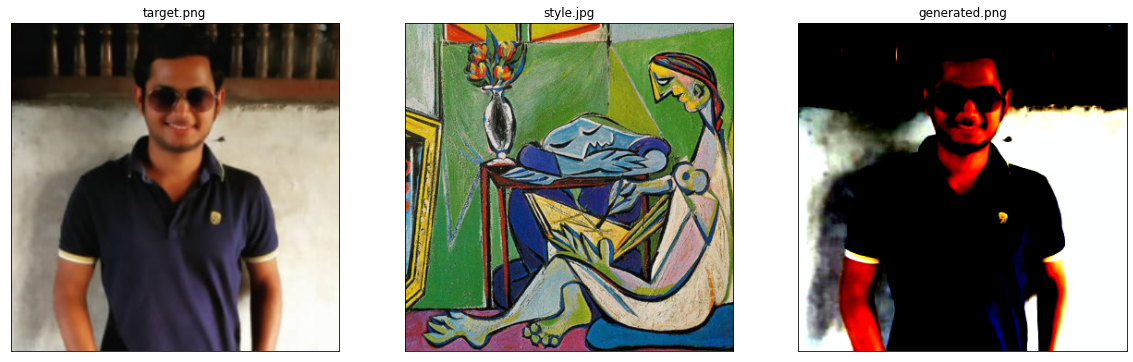

In [135]:
fig = plt.figure(figsize=(20,8))
for idx, label in enumerate(['target.png', 'style.jpg', 'generated.png']):
    ax = plt.subplot(1,3,idx+1, xticks=[], yticks=[])
    plt.imshow(img_convert(loader(Image.open(label))))
    ax.set_title(label)

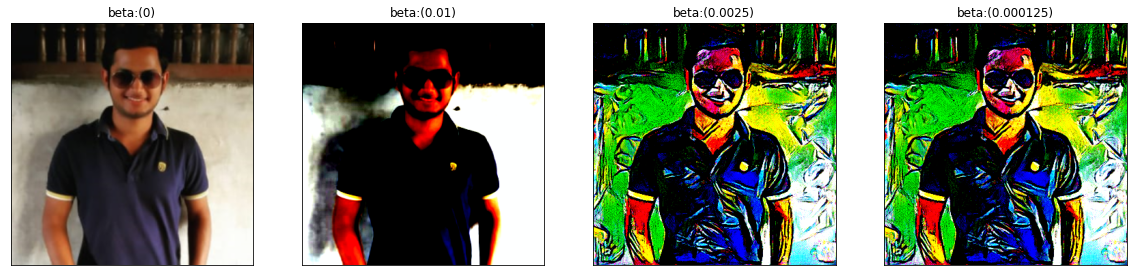

In [141]:
fig = plt.figure(figsize=(20,8))
beta = [0, 0.01, 0.0025, 0.000125]
for idx, label in enumerate(['target.png', 'generated.png', 'generated0025.png', 'generated000125_0.2.png']):
    ax = plt.subplot(1,4,idx+1, xticks=[], yticks=[])
    plt.imshow(img_convert(loader(Image.open(label))))
    ax.set_title(f"beta:({beta[idx]})")